In [1]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object
from neuroformer.visualize import set_plot_params
from neuroformer.SpikeVidUtils import round_n
set_plot_params()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

import argparse
from neuroformer.SpikeVidUtils import round_n
import argparse



# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

set_seed(25)

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    return parser.parse_args()

# if __name__ == "__main__":
#     args = parse_args()
#     INFERENCE = not args.train
# else:
#     INFERENCE = True

# check if jupyter notebook
try:
    shell = get_ipython().__class__.__name__
    print("Running in Jupyter notebook")
    INFERENCE = True
except:
    print("Running in terminal")
    args = parse_args()
    INFERENCE = not args.train

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


Running in Jupyter notebook


In [2]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""

RESPONSE_PATH = "data/Combo3_V1AL/Combo3_V1AL_response.csv"
STIMULUS_PATH = "data/Combo3_V1AL/Combo3_V1AL_stimulus.pt"
DATASET = "Combo3_V1AL"

if not os.path.exists(RESPONSE_PATH):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=share_link"
    gdown.download_folder(id=url, quiet=False, use_cookies=False)



df = pd.read_csv(RESPONSE_PATH)
video_stack = torch.load(STIMULUS_PATH)
stimulus = video_stack[:, :, 0]



torch.Size([3, 640, 1, 64, 112])


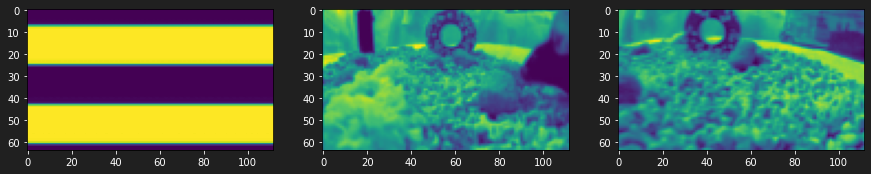

In [3]:
print(video_stack.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(video_stack[i, 1, 0].permute(0, 1))


In [58]:
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
base_path = "./models/tensorboard/V1_AL/downstream/learnt_temporal_embeddings/sparse_f:None_id:None/w:0.05_wp:0.25"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)


In [59]:

if INFERENCE:
    frame_window = mconf.frame_window
    window = mconf.window
    window_prev = mconf.window_prev
    window_behavior = mconf.window_behavior if hasattr(mconf, 'window_behavior') else None
    dt = mconf.dt
    dt_frames = mconf.dt_frames if hasattr(mconf, 'dt_frames') else 0.05
    dt_vars = mconf.dt_vars if hasattr(mconf, 'dt_vars') else 0.05
    dt_speed = mconf.dt_speed if hasattr(mconf, 'dt_speed') else 0.2
    intervals = None
else:
    frame_window = 0.25
    window = 0.05
    window_prev = 0.25
    window_behavior = window
    dt = 0.01
    dt_frames = 0.05
    dt_vars = 0.05
    dt_speed = 0.2
    intervals = None



In [60]:
## choose modalities ##

# behavior
behavior = False
behavior_vars = ['eyerad', 'phi', 'speed', 'th']
# behavior_vars = ['speed']
n_behavior = len(behavior_vars)
predict_behavior = False
# stimulus
visual_stim = True



In [61]:
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals


if behavior is True:
    behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    behavior = behavior.rename(columns={'t': 'Time'}) if behavior is not None else None
    behavior['Interval'] = make_intervals(behavior, window)
    behavior['Interval_2'] = make_intervals(behavior, window_prev)

    # prepare speed variables
    behavior['speed'] = behavior['speed'].apply(lambda x: round_n(x, dt_speed))
    dt_range_speed = behavior['speed'].min(), behavior['speed'].max()
    dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
    n_behavior = len(dt_range_speed)

    stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
    itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)
else:
    behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None

if predict_behavior:
    loss_bprop = ['behavior']
else:
    loss_bprop = None



In [62]:
from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [63]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
# kernel_size = (n_frames, 4, 4)
kernel_size = [n_frames, 8, 8]
stride_size = kernel_size
padding_size = 0
n_embd = 256
n_embd_frames = mconf.n_embd_frames
frame_feats = stimulus if visual_stim else None
frame_block_size = 0
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

prev_id_block_size = 55
id_block_size = 55   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }

/tmp/ipykernel_3210566/3101622180.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame_feats = torch.tensor(stimulus, dtype=torch.float32)


In [64]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

# r_split_ft = np.arange(0, 1, 0.25)
r_split_ft = 0.1
finetune_trials = train_trials[:int(len(train_trials) * r_split_ft)]
finetune_data = df[df['Trial'].isin(finetune_trials)]

n = []
n_trial = [2, 8, 14, 19]
for n_stim in range(df['Trial'].max() // 20):
    # n_trial = [2, 4, 6, 8, 10, 12, 14, 18]
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t)
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)



In [65]:
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed)

test_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed)

finetune_dataset = SpikeTimeVidData2(finetune_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset=DATASET,
                                  behavior=behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed)

if INFERENCE:
    update_object(train_dataset, dconf)
    update_object(test_dataset, dconf)
    update_object(finetune_dataset, dconf)
    
print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')





Population Size:  389
ID Population Size:  389
DT Population Size:  28
Population Size:  389
ID Population Size:  389
DT Population Size:  28
Population Size:  389
ID Population Size:  389
DT Population Size:  28
Setting _is_protocol to False
Setting behavior_block_size to 0
Setting behavior_feats to None
Setting behavior_vars to None
Setting block_size to 110
Setting data_dict to None
Setting dataset to Combo3_V1AL
Setting dt to 0.01
Setting dt_frames to 0.05
Setting dt_max to 27
Setting dt_population_size to 28
Setting dt_speed to 0.2
Setting dt_vars to 0.05
Setting frame_block_size to 0
Setting frame_memory to 4.0
Setting frame_window to 0.25
Setting id_block_size to 55
Setting id_population_size to 389
Setting id_prev_block_size to 55
Setting idx to 0
Setting interval to 0
Setting intervals to None
Setting itos_speed to None
Setting min_interval to 0.3
Setting population_size to 389
Setting pred to False
Setting predict_behavior to False
Setting samples_per_behavior to 0
Setting st

In [66]:
from model_neuroformer import GPT, GPTConfig

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 80
batch_size = round((32 * 2))
shuffle = True

title =  f'large_window_2'

if INFERENCE:
    model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
else:
    model_path = f"""./models/tensorboard/V1_AL/downstream/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=4, n_state_history_layers=4,
                        n_stimulus_layers=4, self_att_layers=0,
                        n_behavior_layers=0, predict_behavior=predict_behavior, n_behavior=n_behavior,
                        n_head=4, n_embd=n_embd, 
                        contrastive=False, clip_emb=1024, clip_temp=mconf.clip_temp,
                        conv_layer=conv_layer, kernel_size=kernel_size, stride_size=stride_size, padding_size=padding_size,
                        temp_emb=mconf.temp_emb, pos_emb=False,
                        id_drop=0.1, im_drop=0.1, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35


if INFERENCE:
    update_object(model_conf, mconf)
model = GPT(model_conf)
# model_weights = "models/tensorboard/visnav/behavior_predict/long_no_classification/finetune/window:0.05_prev:0.25/sparse_f:None_id:None/w:0.05_wp:0.25/6_Cont:False_window:0.05_f_window:0.2_df:0.005_blocksize:100_conv_True_shuffle:True_batch:224_sparse_(None_None)_blocksz446_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_52_max0.005_(8, 8, 8)_8_256.pt"
# if model_weights is not None:
#     model.load_state_dict(torch.load(model_weights), strict=False)

Setting attn_pdrop to 0.2
Setting b_drop to 0.45
Setting behavior_block_size to 0
Setting block_size to 110
Setting class_weights to None
Setting clip_emb to 1024
Setting clip_temp to 2
Setting contrastive to False
Setting conv_layer to True
Setting dt to 0.01
Setting embd_pdrop to 0.2
Setting epoch to 6
Setting frame_block_size to 0
Setting frame_window to 0.25
Setting freeze_weights to None
Setting id_block_size to 55
Setting id_drop to 0.1
Setting id_vocab_size to 389
Setting ignore_index_dt to 27
Setting ignore_index_id to 388
Setting im_drop to 0.1
Setting n_behavior to None
Setting n_behavior_layers to 0
Setting n_dt to 28
Setting n_embd to 256
Setting n_embd_frames to 64
Setting n_head to 4
Setting n_state_history_layers to 4
Setting n_state_layers to 4
Setting n_stimulus_layers to 4
Setting p_sparse to None
Setting padding_size to 0
Setting pos_emb to False
Setting pos_pdrop to 0.2
Setting predict_behavior to False
Setting pretrain to False
Setting prev_id_block_size to 55
Sett

04/14/2023 19:20:14 - INFO - model_neuroformer -   number of parameters: 1.616205e+07


In [67]:
model.config.id_vocab_size

389

In [68]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e4, 
                    decay_weights=True, weight_decay=0.1, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=1000, loss_bprop=loss_bprop)

if not INFERENCE:
    trainer = Trainer(model, finetune_dataset, test_dataset, tconf, model_conf)
    trainer.train()
else:
    model_path = glob.glob(os.path.join(base_path, '**.pt'), recursive=True)[0]
    model.load_state_dict(torch.load(model_path), strict=False)


In [69]:
loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)

In [70]:
# model.eval()
# # model.train()
# for i in range(1):
#     x, y = next(iterable)
#     x_1 = x['id'][0].detach().cpu().numpy()
#     x_pad = x['pad']
#     x_1 = x['id'][:len(x_1) - int(x_pad[0])]
#     preds, features, loss = model(x, y)

#     step_choices = random.sample(range(len(x_1)), min(5, len(x_1)))
#     fig, ax = plt.subplots(1, len(step_choices), figsize=(50, 5))
#     for step in step_choices:
#         step_preds = preds['id'][0, step].detach().cpu().numpy()
#         x_axis = np.arange(0, len(step_preds))
#         ax_step = ax[step]
#         ax_step.scatter(x_axis, step_preds)
#         ax_step.set_title(f"""{step}""", fontsize=20)

In [71]:
x, y = next(iterable)
for k in x.keys():
    print(k, x[k].shape)

id_prev torch.Size([1, 55])
dt_prev torch.Size([1, 55])
pad_prev torch.Size([1])
id torch.Size([1, 55])
dt torch.Size([1, 55])
pad torch.Size([1])
interval torch.Size([1])
trial torch.Size([1])
frames torch.Size([1, 1, 5, 64, 112])
stimulus torch.Size([1])
cid torch.Size([1, 2])
pid torch.Size([1, 2])
f_idx torch.Size([1, 2])


In [72]:
from neuroformer.utils import predict_raster_recursive_time_auto, process_predictions
from joblib import Parallel, delayed

model.load_state_dict(torch.load(model_path))

results_dict = dict()
df_pred = None
df_true = None

top_p = 0.75
top_p_t = 0.75
temp = 1.25
temp_t = 1.25

from joblib import Parallel, delayed
# Define a function to process each trial
def process_trial(model, train_dataset, df, stoi, itos_dt, itos, window, window_prev, top_p, top_p_t, temp, temp_t, trial):
    print(f"-- No. {n} Trial: {trial} --")
    df_trial = df[df['Trial'] == trial]
    trial_dataset = train_dataset.copy(df_trial)
    results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                       sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                       frame_end=0, get_dt=True, gpu=False, pred_dt=True, plot_probs=False)
    df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
    print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
    return df_trial_pred, df_trial_true

if __name__ == '__main__':
    # Define the list of trials to be processed
    trials = sorted(train_data['Trial'].unique())[::4]
    
    # Process each trial in parallel
    results = Parallel(n_jobs=-1)(delayed(process_trial)(model, train_dataset, df, stoi, itos_dt, 
                                                         itos, window, window_prev, top_p, top_p_t, 
                                                         temp, temp_t, trial) for trial in trials)

    # Combine the results from each trial
    for n, (df_trial_pred, df_trial_true) in enumerate(results):   
        print(f"-- No. {n} Trial --")
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])

from neuroformer.analysis import compute_scores
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )


dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)
df_pred.to_csv(os.path.join(dir_name, F'df_pred_.csv'))

-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 2 --
-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 7 --


  0%|          | 0/412 [00:00<?, ?it/s]

-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 11 --


  0%|          | 0/410 [00:00<?, ?it/s]

-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 16 --
-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 22 --


  0%|          | 0/514 [00:00<?, ?it/s]

-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 31 --
-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 27 --


len pred: 2, len true: 10:   1%|          | 2/391 [00:02<05:52,  1.10it/s]

-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 42 --


len pred: 1, len true: 8:   0%|          | 1/412 [00:02<15:40,  2.29s/it]]

-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 36 --
-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 47 --


len pred: 4, len true: 17:   0%|          | 2/412 [00:02<07:14,  1.06s/it]

-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 56 --
-- No. [18, 12, 6, 1, 38, 32, 26, 21, 58, 52, 46, 41] Trial: 51 --


len pred: 535, len true: 1297:  90%|████████▉ | 367/410 [01:00<00:06,  6.98it/s]

pred: (470, 5), true: (1147, 2)


len pred: 510, len true: 1344: 100%|██████████| 418/418 [01:01<00:00,  6.83it/s]


pred: (448, 5), true: (1207, 2)
pred: (446, 5), true: (1344, 2)


len pred: 461, len true: 1076:  90%|█████████ | 380/421 [01:00<00:05,  7.20it/s]

pred: (438, 5), true: (1058, 2)


len pred: 493, len true: 1157:  96%|█████████▋| 406/421 [01:04<00:01,  7.69it/s]

pred: (446, 5), true: (1281, 2)


len pred: 502, len true: 1389:  85%|████████▌ | 414/486 [01:05<00:09,  7.76it/s]

pred: (498, 5), true: (1393, 2)


len pred: 513, len true: 1229:  99%|█████████▉| 423/428 [01:07<00:00,  6.97it/s]

pred: (456, 5), true: (1212, 2)


len pred: 518, len true: 1241: 100%|██████████| 428/428 [01:07<00:00,  6.32it/s]


pred: (503, 5), true: (1297, 2)
pred: (469, 5), true: (1241, 2)


len pred: 586, len true: 1775:  94%|█████████▍| 482/512 [01:16<00:03,  8.65it/s]

pred: (512, 5), true: (1655, 2)


len pred: 601, len true: 2286: 100%|██████████| 514/514 [01:18<00:00,  6.51it/s]


pred: (545, 5), true: (2286, 2)


len pred: 624, len true: 1937: 100%|██████████| 512/512 [01:20<00:00,  6.36it/s]


pred: (559, 5), true: (1937, 2)
-- No. 0 Trial --
-- No. 1 Trial --
-- No. 2 Trial --
-- No. 3 Trial --
-- No. 4 Trial --
-- No. 5 Trial --
-- No. 6 Trial --
-- No. 7 Trial --
-- No. 8 Trial --
-- No. 9 Trial --
-- No. 10 Trial --
-- No. 11 Trial --
defaultdict(<class 'list'>, {'precision': 0.001762977473065622, 'recall': 0.001730329742082925, 'F1': 0.001743388834476004})
pred: 5790, true: 17058


In [73]:
"""

Split data into full-stimulus trials

"""
dir_name = os.path.dirname(model_path)
df_pred = pd.read_csv(os.path.join(dir_name, F'df_pred_.csv'))

from neuroformer.analysis import get_rates_trial, calc_corr_psth, get_accuracy, compute_scores
from neuroformer.SpikeVidUtils import create_full_trial, set_intervals


t_1, t_2 = 35, 36
trial_data_1 = df[df['Trial'] == t_1]
trial_dataset_1 = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
trial_loader_1 = DataLoader(trial_dataset_1, shuffle=False, pin_memory=False)

def loader_trial(df, n_trial):
    trial_data = df[df['Trial'] == n_trial]
    trial_dataset = SpikeTimeVidData2(trial_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
    trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
    return trial_loader

trial_data_1 = loader_trial(df, t_1)
trial_data_2 = loader_trial(df, t_2)

iterable1 = iter(trial_data_1)
iterable2 = iter(trial_data_2)

n_1 = test_data['Trial'].unique()
n_2 = test_data['Trial'].unique() + 1

df_pred_full = create_full_trial(df_pred)
df_1 = create_full_trial(df, trials)
df_2 = create_full_trial(df, n_1)
df_3 = create_full_trial(df, n_2)

# sort by interval, trial
window_pred = 0.5
min_window = window_prev + window
df_pred_full = set_intervals(df_pred_full, window, window_prev, window_pred)
df_1 = set_intervals(df_1, window, window_prev, window_pred)
df_2 = set_intervals(df_2, window, window_prev, window_pred)
df_3 = set_intervals(df_3, window, window_prev, window_pred)

window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

neurons = df['ID'].unique()
top_corr_pred = calc_corr_psth(rates_pred, rates_1, neurons=neurons)
top_corr_real = calc_corr_psth(rates_1, rates_2, neurons=neurons)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3, neurons=neurons)

Population Size:  389
ID Population Size:  389
DT Population Size:  28
Population Size:  389
ID Population Size:  389
DT Population Size:  28
Population Size:  389
ID Population Size:  389
DT Population Size:  28


id_pred: 199, id_true_1: 386, id_true_2: 386
len_pred: 5790, len_true: 11929
real: defaultdict(<class 'list'>, {'precision': 0.376965261139391, 'recall': 0.37691349034677907, 'F1': 0.3679253246400469})
pred: defaultdict(<class 'list'>, {'precision': 0.15489996195641592, 'recall': 0.0987235611468983, 'F1': 0.11896831934907105})


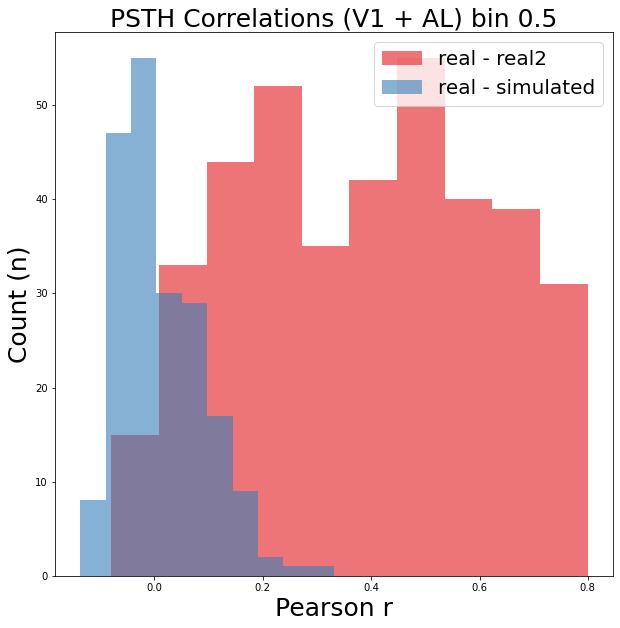

386


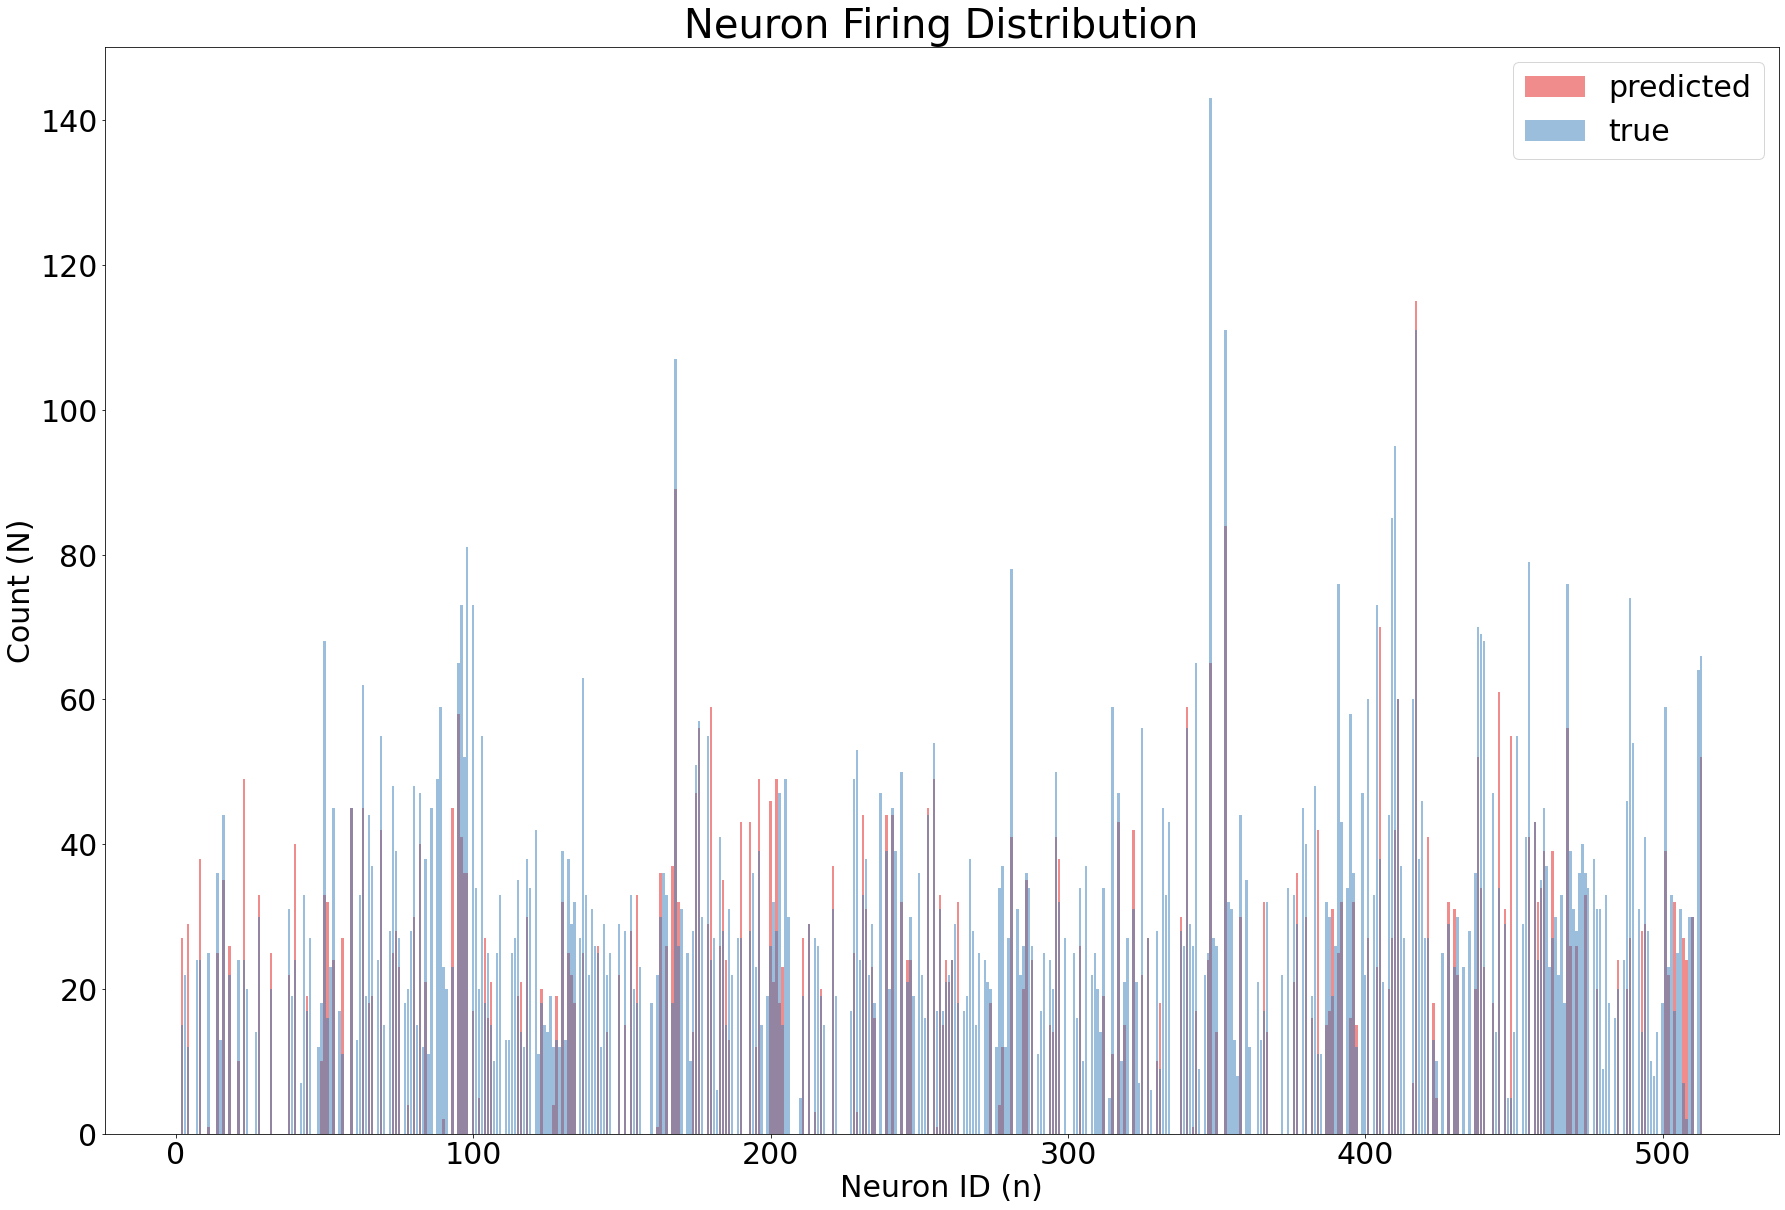

model: large_window_2


In [74]:
"""

Evaluate results

"""


from neuroformer.visualize import set_plot_white, plot_distribution

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")

# dir_name = os.path.dirname(model_path)
dir_name = model_path
model_name = os.path.basename(model_path)
save_dir = model_name
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

df_pred.to_csv(os.path.join(save_dir, F'df_pred.csv'))

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) bin {window_pred}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)
plt.savefig(os.path.join(save_dir, F'psth_corr_{title}.svg'))
plt.show()

plot_distribution(df_1, df_pred, save_path=os.path.join(save_dir, F'psth_dist_{title}.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

print(f"model: {title}")

In [75]:
loader = DataLoader(test_dataset, shuffle=True, pin_memory=False)
iterable = iter(test_dataset)


In [76]:
var_group = 'Interval'
int_trials = df.groupby([var_group, 'Trial']).size()
print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
n_unique = len(df.groupby([var_group, 'Trial']).size())
df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()


2.2172952440017055


Interval  Trial
19.40     21       16
0.40      35       15
6.65      22       14
0.40      34       13
0.60      21       13
                   ..
7.30      20        3
          30        3
          52        3
          54        3
7.35      3         3
Length: 5159, dtype: int64

In [77]:
x, y = next(iterable)

T = len(x['id'])
P = x['pad']
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

T_y = len(y['id'])
P_y = x['pad']

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]
xdt = x['dt'][: T - P]

yid = y['id'][: T_y - P_y]
yid = [itos[int(i)] for i in yid]
ydt = y['dt'][: T - P]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")
print(f"xdt: {xdt}")
print(f"y: {yid}")
print(f"ydt: {ydt}")

print(f"xid_prev: {xid_prev}")

tdiff = 0
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

# t_var = 'Time' # 'Interval'
# int_var = 'pid'
# df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))

# print(f"trial: {x['trial']}, pid: {x['pid']}, cid: {x['cid']}")

# plt.imshow(x['frames'][0, 0])

iv: 0.25, ix+window: 0.3 pid: tensor([0.0000, 0.2500]) cid: tensor([0.2500, 0.3000])
x: ['SOS', 379, 488, 416, 358]
xdt: tensor([0., 0., 2., 3., 4.])
y: [379, 488, 416, 358, 'EOS']
ydt: tensor([ 0,  2,  3,  4, 26])
xid_prev: ['SOS', 45, 440, 416, 479, 477, 451, 512, 513, 509, 417, 'EOS', 'PAD', 'PAD', 'PAD']


,Unnamed: 0,Time,ID,Trial,Interval,real_interval,Interval_2
923,923,0.254878,379,2,0.3,0.3,0.5
924,924,0.266816,488,2,0.3,0.3,0.5
925,925,0.284546,416,2,0.3,0.3,0.5
926,926,0.289153,358,2,0.3,0.3,0.5


In [78]:
itos_dt

{0: 0.0,
 1: 0.01,
 2: 0.02,
 3: 0.03,
 4: 0.04,
 5: 0.05,
 6: 0.06,
 7: 0.07,
 8: 0.08,
 9: 0.09,
 10: 0.1,
 11: 0.11,
 12: 0.12,
 13: 0.13,
 14: 0.14,
 15: 0.15,
 16: 0.16,
 17: 0.17,
 18: 0.18,
 19: 0.19,
 20: 0.2,
 21: 0.21,
 22: 0.22,
 23: 0.23,
 24: 0.24,
 25: 0.25,
 26: 'EOS',
 27: 'PAD'}

In [79]:
loader = DataLoader(test_dataset, shuffle=True, pin_memory=False)
iterable = iter(loader)

In [81]:
x, y = next(iterable)
preds, features, loss = model(x, y)

KeyboardInterrupt: 